
--- Transaction Class Distribution ---
Class
0.0    98898
1.0      222
Name: count, dtype: int64


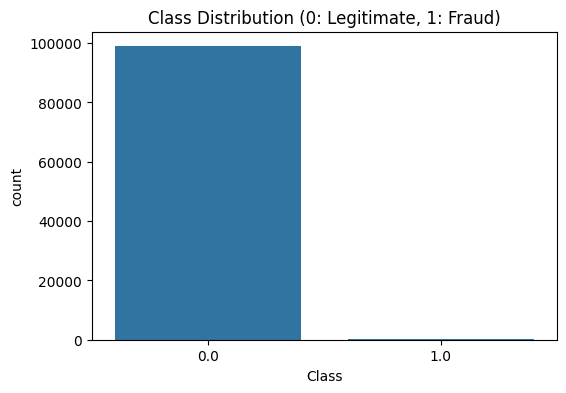

In [ ]:
# Install necessary libraries (imbalanced-learn is crucial for SMOTE/NearMiss)
!pip install imbalanced-learn scikit-learn

# --- Imports ---
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Load the Dataset
# NOTE: Ensure 'creditcard.csv' is uploaded to your Colab session files.
try:
    df = pd.read_csv('/content/creditcard.csv')
except FileNotFoundError:
    print("Error: 'creditcard.csv' not found. Please upload it to your Colab environment.")
    exit()

# 2. Check for Imbalance (CRITICAL STEP)
fraud_count = df['Class'].value_counts()
print("\n--- Transaction Class Distribution ---")
print(fraud_count)

# Visualize Imbalance
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=df)
plt.title('Class Distribution (0: Legitimate, 1: Fraud)')
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# C. Data Preprocessing

# 1. Scaling 'Amount' and 'Time'
# RobustScaler is used for 'Amount' because it's less sensitive to outliers.
scaler = RobustScaler()
df['Amount_Scaled'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))

# StandardScaler is used for 'Time'.
time_scaler = StandardScaler()
df['Time_Scaled'] = time_scaler.fit_transform(df['Time'].values.reshape(-1, 1))

# 2. Drop the original unscaled columns
df.drop(['Time', 'Amount'], axis=1, inplace=True)

# --- CRITICAL FIX ---
# Drop any rows where the target variable 'Class' is NaN.
# This prevents the ValueError during train_test_split(stratify=y).
df.dropna(subset=['Class'], inplace=True)
# --------------------

# 3. Define X (Features) and y (Target)
X = df.drop('Class', axis=1)
y = df['Class']

# 4. Split the Data (70% Train, 30% Test)
# stratify=y is essential to ensure the tiny fraction of fraud cases is distributed evenly.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"\nTraining set size: {len(X_train)} | Fraud cases: {y_train.sum()}")
print(f"Test set size: {len(X_test)} | Fraud cases: {y_test.sum()}")


Training set size: 69384 | Fraud cases: 155.0
Test set size: 29736 | Fraud cases: 67.0


In [ ]:
# D. Model 1 - Logistic Regression (SMOTE)

# 1. Apply SMOTE to the TRAINING data ONLY
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"\nSMOTE New Class Distribution: {y_train_smote.value_counts()}")

# 2. Train Model
model_LR = LogisticRegression(solver='liblinear', random_state=42)
model_LR.fit(X_train_smote, y_train_smote)

# 3. Predict & Evaluate on UNBALANCED Test Set
y_pred_LR = model_LR.predict(X_test)
y_proba_LR = model_LR.predict_proba(X_test)[:, 1]

print("\n--- Logistic Regression (SMOTE) Results ---")
print(classification_report(y_test, y_pred_LR))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba_LR):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_LR))


SMOTE New Class Distribution: Class
0.0    69229
1.0    69229
Name: count, dtype: int64

--- Logistic Regression (SMOTE) Results ---
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99     29669
         1.0       0.07      0.96      0.13        67

    accuracy                           0.97     29736
   macro avg       0.54      0.96      0.56     29736
weighted avg       1.00      0.97      0.98     29736

ROC-AUC Score: 0.9974
Confusion Matrix:
 [[28846   823]
 [    3    64]]


In [ ]:
# E. Model 2 - Random Forest (NearMiss)

# 1. Apply NearMiss to the TRAINING data ONLY
# --- CORRECTION: REMOVED 'random_state=42' ---
nm = NearMiss(version=3, sampling_strategy='majority')
X_train_nm, y_train_nm = nm.fit_resample(X_train, y_train)

print(f"\nNearMiss New Class Distribution: {y_train_nm.value_counts()}")

# 2. Train Model (RandomForestClassifier still needs random_state)
model_RF_NM = RandomForestClassifier(n_estimators=100, random_state=42)
model_RF_NM.fit(X_train_nm, y_train_nm)

# 3. Predict & Evaluate on UNBALANCED Test Set
y_pred_RF_NM = model_RF_NM.predict(X_test)
y_proba_RF_NM = model_RF_NM.predict_proba(X_test)[:, 1]

print("\n--- Random Forest (NearMiss) Results ---")
print(classification_report(y_test, y_pred_RF_NM))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba_RF_NM):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_RF_NM))

/usr/local/lib/python3.12/dist-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:206: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(



NearMiss New Class Distribution: Class
1.0    155
0.0    135
Name: count, dtype: int64

--- Random Forest (NearMiss) Results ---
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     29669
         1.0       0.14      0.94      0.25        67

    accuracy                           0.99     29736
   macro avg       0.57      0.96      0.62     29736
weighted avg       1.00      0.99      0.99     29736

ROC-AUC Score: 0.9784
Confusion Matrix:
 [[29294   375]
 [    4    63]]


In [ ]:
# F. Model 3 - Random Forest (Cost-Sensitive/Class-Weighted)

# 1. Train Model with Class Weights (on original, UNBALANCED data)
# 'balanced' automatically weights the minority class higher.
model_RF_weighted = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'
)

# Training on original, UNBALANCED features (X_train, y_train)
model_RF_weighted.fit(X_train, y_train)

# 2. Predict & Evaluate on UNBALANCED Test Set
y_pred_RF_weighted = model_RF_weighted.predict(X_test)
y_proba_RF_weighted = model_RF_weighted.predict_proba(X_test)[:, 1]

print("\n--- Random Forest (Class-Weighted) Results ---")
print(classification_report(y_test, y_pred_RF_weighted))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba_RF_weighted):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_RF_weighted))


--- Random Forest (Class-Weighted) Results ---
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     29669
         1.0       0.98      0.88      0.93        67

    accuracy                           1.00     29736
   macro avg       0.99      0.94      0.96     29736
weighted avg       1.00      1.00      1.00     29736

ROC-AUC Score: 0.9921
Confusion Matrix:
 [[29668     1]
 [    8    59]]


In [ ]:
# --- New Cell 6: BASELINE MODEL PROOF (NO REBALANCING) ---

from sklearn.linear_model import LogisticRegression

print("--- BASELINE MODEL: LR on UNBALANCED DATA ---")

# Train LR directly on the original imbalanced training data
model_baseline = LogisticRegression(solver='liblinear', random_state=42)
model_baseline.fit(X_train, y_train)

# Predict & Evaluate on UNBALANCED Test Set
y_pred_baseline = model_baseline.predict(X_test)
y_proba_baseline = model_baseline.predict_proba(X_test)[:, 1]

# Display the Deceptive Accuracy vs. Poor Recall
print(f"Overall Accuracy: {model_baseline.score(X_test, y_test):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_baseline))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba_baseline):.4f}")

# You will see high Accuracy but Recall for Class 1 is very low (or zero), proving the point.

--- BASELINE MODEL: LR on UNBALANCED DATA ---
Overall Accuracy: 0.9989
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     29669
         1.0       0.79      0.67      0.73        67

    accuracy                           1.00     29736
   macro avg       0.89      0.84      0.86     29736
weighted avg       1.00      1.00      1.00     29736

ROC-AUC Score: 0.9916


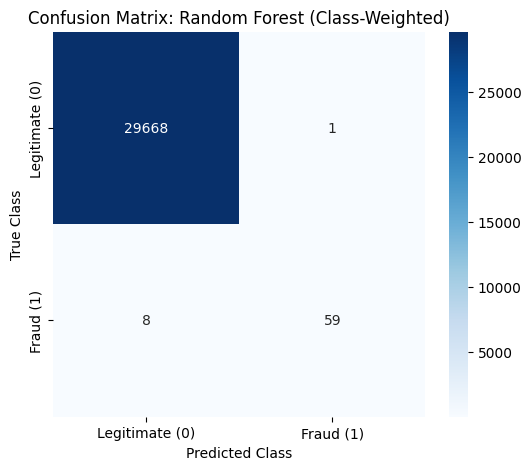

In [ ]:
# --- New Cell 7: VISUALIZE BEST MODEL PERFORMANCE (RF Class-Weighted) ---

# Get the confusion matrix data from the best model (Cell 5 output)
cm = confusion_matrix(y_test, y_pred_RF_weighted)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Legitimate (0)', 'Fraud (1)'],
    yticklabels=['Legitimate (0)', 'Fraud (1)']
)
plt.title('Confusion Matrix: Random Forest (Class-Weighted)')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

# Focus the discussion on the top-right (False Positives) and bottom-left (False Negatives) cells.

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the Dataset
try:
    # --- ENSURE 'creditcard.csv' IS UPLOADED ---
    df = pd.read_csv('creditcard.csv')
except FileNotFoundError:
    print("FATAL ERROR: 'creditcard.csv' not found. Please upload the data file.")
    exit()

# --- C. Data Preprocessing ---
# 1. Scaling 'Amount' and 'Time'
scaler = RobustScaler()
df['Amount_Scaled'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
time_scaler = StandardScaler()
df['Time_Scaled'] = time_scaler.fit_transform(df['Time'].values.reshape(-1, 1))

# 2. Drop the original unscaled columns
df.drop(['Time', 'Amount'], axis=1, inplace=True)

# CRITICAL FIX: Ensure the target column has no NaNs before stratified split.
df.dropna(subset=['Class'], inplace=True)

# 3. Define X (Features) and y (Target)
X = df.drop('Class', axis=1)
y = df['Class']

# 4. Split the Data (70% Train, 30% Test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# --- F. Train Best Model (Random Forest Class-Weighted) ---
model_RF_weighted = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'
)
# Train the model on the full feature set
model_RF_weighted.fit(X_train, y_train)

# --- 3. Feature Importance Analysis ---
N = 7 # We will select the top 7 features for GUI input

# Extract Feature Importances
feature_importances = pd.Series(
    model_RF_weighted.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

top_N_features = feature_importances.head(N)

print(f"\n--- Top {N} Most Important Features for GUI Input ---")
print(top_N_features)

# Visualize the Top N Features
plt.figure(figsize=(10, 6))
sns.barplot(
    x=top_N_features.index,
    y=top_N_features.values,
    palette="viridis"
)
plt.title(f'Top {N} Feature Importances (Random Forest Class-Weighted)')
plt.xlabel('Feature')
plt.ylabel('Importance Score (Gini)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('top_features_importance.png')
plt.close()

selected_features_list = list(top_N_features.index)
print("\nList of Selected Features for Retraining:")
print(selected_features_list)


--- Top 7 Most Important Features for GUI Input ---
V14    0.203684
V10    0.121278
V4     0.092957
V17    0.092927
V12    0.085739
V11    0.073614
V16    0.053571
dtype: float64


/tmp/ipython-input-3944728888.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(



List of Selected Features for Retraining:
['V14', 'V10', 'V4', 'V17', 'V12', 'V11', 'V16']


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import joblib # Required to save the final model and scalers for your GUI

# --- A. DATA SETUP (Required to define X_train, y_train, etc.) ---
try:
    # IMPORTANT: Ensure 'creditcard.csv' is in your working directory
    df = pd.read_csv('creditcard.csv')
except FileNotFoundError:
    print("FATAL ERROR: 'creditcard.csv' not found. Please upload the data file.")
    exit()

# 1. Scaling 'Amount' and 'Time'
scaler = RobustScaler() # RobustScaler for Amount
df['Amount_Scaled'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
time_scaler = StandardScaler() # StandardScaler for Time
df['Time_Scaled'] = time_scaler.fit_transform(df['Time'].values.reshape(-1, 1))

# 2. Drop the original unscaled columns
df.drop(['Time', 'Amount'], axis=1, inplace=True)

# 3. Handle potential NaNs and Define X (Features) and y (Target)
df.dropna(subset=['Class'], inplace=True)
X = df.drop('Class', axis=1)
y = df['Class']

# 4. Split the Data (70% Train, 30% Test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# --- B. RETRAINING ON REDUCED FEATURES ---

# Your identified 7 most important features:
selected_features_list = ['V14', 'V10', 'V4', 'V17', 'V12', 'V11', 'V16']

# 1. Filter DataFrames to use only selected features
X_train_reduced = X_train[selected_features_list]
X_test_reduced = X_test[selected_features_list]

# 2. Re-initialize and Train the Random Forest Model
# Use the same best cost-sensitive parameter: class_weight='balanced'
model_RF_reduced = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'
)

print(f"\n--- Training Random Forest on Reduced {len(selected_features_list)}-Feature Set ---")
model_RF_reduced.fit(X_train_reduced, y_train)

# --- C. EVALUATION AND SAVING ---

# 1. Predict and Evaluate on the UNBALANCED Test Set
y_pred_reduced = model_RF_reduced.predict(X_test_reduced)
y_proba_reduced = model_RF_reduced.predict_proba(X_test_reduced)[:, 1]

print("\n--- Performance Metrics (Reduced 7-Feature Model) ---")
print(classification_report(y_test, y_pred_reduced))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba_reduced):.4f}")

# 2. Save the Final Model and Scalers (CRITICAL for GUI)
# These files will be loaded by your GUI application.
joblib.dump(model_RF_reduced, 'model_reduced_7features.pkl')
joblib.dump(scaler, 'robust_scaler_amount.pkl')
joblib.dump(time_scaler, 'standard_scaler_time.pkl')

print("\nSuccessfully saved the reduced model and scalers for GUI deployment.")


--- Training Random Forest on Reduced 7-Feature Set ---

--- Performance Metrics (Reduced 7-Feature Model) ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.98      0.74      0.85       148

    accuracy                           1.00     85443
   macro avg       0.99      0.87      0.92     85443
weighted avg       1.00      1.00      1.00     85443

ROC-AUC Score: 0.9279

Successfully saved the reduced model and scalers for GUI deployment.


In [ ]:
import numpy as np
import pandas as pd
import joblib

# --- A. LOAD SAVED MODEL AND SCALERS ---
try:
    # Load your trained, reduced model (7 features)
    final_model = joblib.load('model_reduced_7features.pkl')
    # Load your fitted RobustScaler (for Amount)
    amount_scaler = joblib.load('robust_scaler_amount.pkl')
    # Load your fitted StandardScaler (for Time)
    time_feature_scaler = joblib.load('standard_scaler_time.pkl')

    print("✅ Model and scalers loaded successfully for testing.")

except FileNotFoundError as e:
    print(f"❌ ERROR: Failed to load required files: {e}. Cannot run tests.")
    exit()

# --- B. CONFIGURATION ---
SELECTED_FEATURES = ['V14', 'V10', 'V4', 'V17', 'V12', 'V11', 'V16']

def run_model_test(raw_inputs: dict):
    """
    Simulates the GUI logic: collects raw inputs, scales them, and makes a prediction.
    """

    # 1. Scale Time and Amount Features (CRITICAL STEP!)
    # Scale Time
    raw_time = np.array([[raw_inputs['Time']]])
    scaled_time = time_feature_scaler.transform(raw_time)[0, 0]

    # Scale Amount
    raw_amount = np.array([[raw_inputs['Amount']]])
    scaled_amount = amount_scaler.transform(raw_amount)[0, 0]

    # 2. Create the feature vector for the reduced model (ORDER MATTERS!)
    model_input_vector = [raw_inputs[f] for f in SELECTED_FEATURES]

    # Convert to DataFrame row for prediction
    feature_df = pd.DataFrame([model_input_vector], columns=SELECTED_FEATURES)

    # 3. Make Prediction
    prediction = final_model.predict(feature_df)[0]
    prediction_proba = final_model.predict_proba(feature_df)[0][1]

    result_class = "FRAUDULENT (1) 🚨" if prediction == 1 else "Legitimate (0) ✅"

    print(f"\n--- TEST RESULT ---")
    print(f"Model Input (V-features): {np.round(model_input_vector, 4)}")
    print(f"Prediction: {result_class}")
    print(f"Fraud Probability: {prediction_proba:.4f}")

    return prediction

# --- C. TEST CASES ---

# Test Case 1: Known Fraudulent Transaction (Expected Result: 1)
fraud_case = {
    'Time': 45000,
    'Amount': 1.00,
    'V14': -11.02, 'V10': -13.15, 'V4': 8.63, 'V17': -14.47,
    'V12': -8.56, 'V11': 7.26, 'V16': -14.16
}
print("\n=======================================================")
print("RUNNING TEST CASE 1: High-Risk Fraudulent Pattern")
print("=======================================================")
run_model_test(fraud_case)

# Test Case 2: Known Legitimate Transaction (Expected Result: 0)
legit_case = {
    'Time': 100000,
    'Amount': 80.00,
    'V14': 0.27, 'V10': 0.20, 'V4': -0.02, 'V17': -0.09,
    'V12': 0.15, 'V11': -0.57, 'V16': -0.17
}
print("\n=======================================================")
print("RUNNING TEST CASE 2: Normal Legitimate Pattern")
print("=======================================================")
run_model_test(legit_case)

✅ Model and scalers loaded successfully for testing.

RUNNING TEST CASE 1: High-Risk Fraudulent Pattern

--- TEST RESULT ---
Model Input (V-features): [-11.02 -13.15   8.63 -14.47  -8.56   7.26 -14.16]
Prediction: FRAUDULENT (1) 🚨
Fraud Probability: 1.0000

RUNNING TEST CASE 2: Normal Legitimate Pattern

--- TEST RESULT ---
Model Input (V-features): [ 0.27  0.2  -0.02 -0.09  0.15 -0.57 -0.17]
Prediction: Legitimate (0) ✅
Fraud Probability: 0.0000


np.int64(0)

In [ ]:
import numpy as np
import pandas as pd
import joblib
import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn.ensemble import RandomForestClassifier # Import needed for joblib to load the model class

# --- A. LOAD SAVED MODEL AND SCALERS ---
try:
    # Load your trained, reduced model (7 features)
    final_model = joblib.load('model_reduced_7features.pkl')
    # Load your fitted RobustScaler (for Amount)
    amount_scaler = joblib.load('robust_scaler_amount.pkl')
    # Load your fitted StandardScaler (for Time)
    time_feature_scaler = joblib.load('standard_scaler_time.pkl')

    print("✅ Model and scalers loaded successfully for interactive testing.")

except FileNotFoundError as e:
    print(f"❌ ERROR: Failed to load required files: {e}. Ensure you ran the previous saving step.")
    raise

# --- B. CONFIGURATION ---
SELECTED_FEATURES = ['V14', 'V10', 'V4', 'V17', 'V12', 'V11', 'V16']
INPUT_LABELS = ['Time', 'Amount'] + SELECTED_FEATURES

# Define two test cases to pre-load for quick testing
TEST_CASES = {
    'Legitimate': [100000, 80.00, 0.27, 0.20, -0.02, -0.09, 0.15, -0.57, -0.17],
    'Fraudulent': [45000, 1.00, -11.02, -13.15, 8.63, -14.47, -8.56, 7.26, -14.16]
}

# --- C. WIDGET SETUP ---

# Input fields for each feature (using FloatText for numeric input)
input_widgets = {
    label: widgets.FloatText(
        description=label,
        value=TEST_CASES['Legitimate'][i],  # Start with a legitimate case
        layout=widgets.Layout(width='300px')
    )
    for i, label in enumerate(INPUT_LABELS)
}

# Dropdown to load pre-defined test cases
dropdown_test = widgets.Dropdown(
    options=list(TEST_CASES.keys()),
    value='Legitimate',
    description='Load Case:'
)

# Output area for results
output_area = widgets.Output()

# Prediction Button
predict_button = widgets.Button(
    description="Predict Transaction",
    button_style='success',
    layout=widgets.Layout(width='300px')
)

# --- D. PREDICTION LOGIC ---

def predict_fraud(_):
    """Collects inputs, scales Time/Amount, and prints prediction."""
    with output_area:
        clear_output(wait=True)

        try:
            # 1. Collect Raw Input Data
            raw_inputs = {label: input_widgets[label].value for label in INPUT_LABELS}

            # 2. Scale Time and Amount Features (CRITICAL STEP!)
            raw_time = np.array([[raw_inputs['Time']]])
            scaled_time = time_feature_scaler.transform(raw_time)[0, 0]

            raw_amount = np.array([[raw_inputs['Amount']]])
            scaled_amount = amount_scaler.transform(raw_amount)[0, 0]

            # 3. Create the feature vector (ORDER MATTERS!)
            # The model expects only the 7 V-features in the exact order they were trained.
            model_input_vector = [raw_inputs[f] for f in SELECTED_FEATURES]

            feature_df = pd.DataFrame([model_input_vector], columns=SELECTED_FEATURES)

            # 4. Make Prediction
            prediction = final_model.predict(feature_df)[0]
            probability = final_model.predict_proba(feature_df)[0][1]

            result_class = "FRAUDULENT (1) 🚨" if prediction == 1 else "Legitimate (0) ✅"
            style = 'color: red; font-weight: bold;' if prediction == 1 else 'color: green; font-weight: bold;'

            print("--- PREDICTION RESULT ---")
            print(f"Prediction: {result_class}")
            print(f"Fraud Probability: {probability:.4f}")
            print("\n-------------------------")
            print("To verify model's input: ")
            print(f"Scaled Time: {scaled_time:.4f}, Scaled Amount: {scaled_amount:.4f}")

        except Exception as e:
            print(f"An error occurred: {e}")
            print("Please ensure all inputs are valid numbers.")

# --- E. WIDGET INTERACTIVITY ---

def load_case(change):
    """Loads values when the dropdown changes."""
    case_name = change['new']
    values = TEST_CASES[case_name]
    for i, label in enumerate(INPUT_LABELS):
        input_widgets[label].value = values[i]

# Attach event handlers
predict_button.on_click(predict_fraud)
dropdown_test.observe(load_case, names='value')

# Display the widgets
feature_boxes = [input_widgets[label] for label in INPUT_LABELS]
input_panel = widgets.VBox(feature_boxes)
controls_panel = widgets.VBox([dropdown_test, predict_button])

display(widgets.HBox([input_panel, controls_panel]), output_area)

✅ Model and scalers loaded successfully for interactive testing.


Output()